In [1]:
import json

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
### file conversion ###

In [3]:
def file_converter(filename_json):
    
    file = open(filename_json)
    data = json.load(file)

    events = []
    for obj in data:
        events.append(obj["eventDescription"])

    count_start = 0
    count_so = 0
    count_ta = 0
    count_sta = 0
    count_end = 0
    
    for obj in data:
        if obj["eventDescription"] == "trial start":
            count_start += 1
        elif obj["eventDescription"] == "slice onset":
            count_so += 1
        elif obj["eventDescription"] == "trigger activation":
            count_ta += 1
        elif obj["eventDescription"] == "server-selected trigger activation":
            count_sta += 1
        elif obj["eventDescription"] == "trial end":
            count_end += 1

    count_events = {"count_start":count_start,
                   "count_so":count_so,
                   "count_ta":count_ta,
                   "count_sta":count_sta,
                   "count_end":count_end}

    df = pd.json_normalize(data)
    df_cols = df.columns.tolist()
    
    return df, count_events

In [4]:
### preprocessing ###

In [5]:
def prep_time(df):

    # timeApplication adjustment
    
    time_ref = float(df.iloc[0, df.columns.get_loc("timeApplication")])

    for i in range(df.shape[0]):
        df.iloc[i, df.columns.get_loc("timeApplication")] = float(df.iloc[i, df.columns.get_loc("timeApplication")]) - time_ref
    
    return df

In [6]:
def prep_fillna(df):
    
    # filling missing values: trialNum

    df.loc[0, "data.trialNum"]= 0
    df["data.trialNum"].fillna(method="ffill", inplace=True)

    # filling missing values: coordinates

#    df["data.playerPosition.0.location.x"].fillna(method="ffill", inplace=True)
#    df["data.playerPosition.0.location.y"].fillna(method="ffill", inplace=True)
#    df["data.playerPosition.0.location.z"].fillna(method="ffill", inplace=True)
#    df["data.playerPosition.1.location.x"].fillna(method="ffill", inplace=True)
#    df["data.playerPosition.1.location.y"].fillna(method="ffill", inplace=True)
#    df["data.playerPosition.1.location.z"].fillna(method="ffill", inplace=True)

    return df

In [7]:
def split_trials(df):
    
    triggerNum = get_triggerNum(df)
    
    trials_dict = {}
    
    for i in triggerNum:
        df_trial = df[df["data.trialNum"] == i]

        #start_id = df_trial[df_trial["eventDescription"] == "trial start"].index[0]
        #end_id = df_trial[df_trial["eventDescription"] == "trial end"].index[0]
        
        #df_trial_startend = df_trial.loc[start_id:end_id]
        
        trials_dict[f"trial {int(i)}"] = df_trial #df_trial_startend
    
    return trials_dict

In [8]:
def prep_concat(df_list):

    df_now = df_list[0].copy()
    df_now = prep_time(df_now)
    df_now = prep_fillna(df_now)

    for i in range(1, len(df_list)):

        # define pre & post dataframes

        df_pre = df_now.copy() # from 0 to i-1
        df_post = df_list[i].copy() # i
        
        # set starting time of post to ending time of pre
        
        time_ref = df_pre.iloc[-1, df_pre.columns.get_loc("timeApplication")]
        df_post.iloc[0, df_post.columns.get_loc("timeApplication")] == time_ref
        
        # set starting trialNum of post to add ending trialNum of pre
        
        df_sta_pre = df_pre[df_pre.eventDescription == "server-selected trigger activation"]
        trialNum_ref = df_sta_pre.iloc[-1, df_sta_pre.columns.get_loc("data.trialNum")]
        
        id_addition = df_post[df_post.eventDescription == "trial start"].index.tolist()
        
        for j in id_addition:
            
            df_post.iloc[j, df_post.columns.get_loc("data.trialNum")] += trialNum_ref
        
        # processing
        
        df_post = prep_time(df_post) # 1st step: time to ref
        df_post = prep_fillna(df_post) # 2nd step: filling missing trialNum & playerPositions
        
        df_now = pd.concat([df_pre, df_post], ignore_index=True) # 3rd step: concat
    
    return df_now

In [9]:
### improvements: ###
# checkpoint for eventDescription numbers
# checkpoint for time continuity
# checkpoint for missing data

In [10]:
### get_information ###

In [11]:
def get_trialNum(df):

    df_te = df[df.eventDescription == "trial end"]
    trialNum = df_te["data.trialNum"].tolist()

    return trialNum ### "Num" starts from (trial/trigger) 1 instead of 0 ###

In [12]:
def get_triggerNum(df):
    
    df_sta = df[df.eventDescription == "server-selected trigger activation"]
    triggerNum = df_sta["data.trialNum"].tolist()

    return triggerNum ### "Num" starts from (trial/trigger) 1 instead of 0 ###

In [13]:
def get_trialType(df): # highlow/forcedhigh/forcedlow
    
    df_ts = df[df.eventDescription == "trial start"]
    trialType = df_ts["data.trialType"].tolist()

    return trialType

In [14]:
def get_trialType_triggerNum(df):
    
    trialType = get_trialType(df)
    
    highlow_tn = []
    fhigh_tn = []
    flow_tn = []
    
    for i in range(len(trialType)):
        if trialType[i] == "HighLow":
            highlow_tn.append(i)
        elif trialType[i] == "ForcedHigh":
            fhigh_tn.append(i)
        elif trialType[i] == "ForcedLow":
            flow_tn.append(i)

    return highlow_tn, fhigh_tn, flow_tn

In [15]:
def get_triggerClient(df): # 0/1

    df_sta = df[df.eventDescription == "server-selected trigger activation"]
    triggerClient = df_sta["data.triggerClient"].tolist()

    return triggerClient

In [16]:
def get_triggerClient_triggerNum(df):

    triggerClient = get_triggerClient(df)
    
    client0_tn = []
    client1_tn = []
    
    for i in range(len(triggerClient)):
        if triggerClient[i] == 0:
            client0_tn.append(i)
        elif triggerClient[i] == 1:
            client1_tn.append(i)

    return client0_tn, client1_tn

In [17]:
def get_triggerType(df): # high/low
    
    df_sta = df[df.eventDescription == "server-selected trigger activation"]
    
    wall_h = df_sta["data.wall1"].tolist()
    wall_l = df_sta["data.wall2"].tolist()
    wallTriggered = df_sta["data.wallTriggered"].tolist()
    
    triggerType = []

    for i in range(len(wallTriggered)):
        if wallTriggered[i] == wall_h[i]:
            triggerType.append("high")
        elif wallTriggered[i] == wall_l[i]:
            triggerType.append("low")
    
    return triggerType

In [18]:
def get_triggerType_triggerNum(df):

    triggerType = get_triggerType(df)
    
    highTrigger_tn = []
    lowTrigger_tn = []
    
    for i in range(len(triggerClient)):
        if triggerType[i] == "high":
            highTrigger_tn.append(i)
        elif triggerType[i] == "low":
            lowTrigger_tn.append(i)

    return highTrigger_tn, lowTrigger_tn

In [19]:
def get_rt(df):

    df_so = df[df.eventDescription == "slice onset"]
    df_sta = df[df.eventDescription == "server-selected trigger activation"]
    triggerNum = get_triggerNum(df)

    rt = []

    for i in triggerNum:
        
        t_so = df_so.iloc[int(i-1), df_so.columns.get_loc("timeApplication")]
        t_sta = df_sta.iloc[int(i-1), df_sta.columns.get_loc("timeApplication")]
        rt.append(float(t_sta) - float(t_so))

    return rt

In [20]:
def get_scores(df):

    df_te = df[df.eventDescription == "trial end"]

    playerScores_0 = df_te["data.playerScores.0"].tolist() if "data.playerScores.0" in df.columns else []
    playerScores_1 = df_te["data.playerScores.1"].tolist() if "data.playerScores.1" in df.columns else []
        
    return playerScores_0, playerScores_1

In [21]:
### wall information ###

In [22]:
def get_wallInfo(df):

    df_sta = df[df.eventDescription == "server-selected trigger activation"]
    triggerNum = get_triggerNum(df)
    
    # triggered walls
    
    wallTriggered = df_sta["data.wallTriggered"].tolist()

    wall_types = []

    for i in range(len(triggerNum)):
    
        wall_h = df_sta.iloc[i, df_sta.columns.get_loc("data.wall1")]
        wall_l = df_sta.iloc[i, df_sta.columns.get_loc("data.wall2")]

        if wallTriggered[i] == wall_h:
            wall_types.append("purple") # high
        elif wallTriggered[i] == wall_l:
            wall_types.append("pink") # low
        else:
            wall_types.append("red") # error
    
    # wall separation: angles of clockwise separation from wall_h to wall_l

    wall_separations = []

    for i in range(len(triggerNum)):

        wall_h = df_sta.iloc[i, df_sta.columns.get_loc("data.wall1")]
        wall_l = df_sta.iloc[i, df_sta.columns.get_loc("data.wall2")]
    
        if wall_h < wall_l:
            wall_separation = (wall_l - wall_h)*np.pi/4 # 2π/8
            wall_separations.append(wall_separation)
        elif wall_h > wall_l:
            wall_separation = (wall_l+8 - wall_h)*np.pi/4 # 2π/8
            wall_separations.append(wall_separation)
    
    # wall rotation: clockwise rotation of wall_h from wall1; to be rotated anticlockwise back to wall 1

    wall_rotations = []
    
    for i in range(len(triggerNum)):

        wall_h = df_sta.iloc[i, df_sta.columns.get_loc("data.wall1")]
        wall_l = df_sta.iloc[i, df_sta.columns.get_loc("data.wall2")]
        
        wall_rotation = (wall_h - 1)*np.pi/4 # 2π/8
        wall_rotations.append(wall_rotation)
    
    # wall clock: wall_h -> wall_l clockwise/anticlockwise

    wall_clocks = []

    for i in range(len(triggerNum)):
    
        if wall_separations[i] <= np.pi:
            wall_clocks.append("c")
        elif wall_separations[i] > np.pi:
            wall_clocks.append("ac")
    
    wallInfo_dict = {"wall_types":wall_types,
                 "wall_separations":wall_separations,
                 "wall_rotations":wall_rotations,
                 "wall_clocks":wall_clocks}
    
    return wallInfo_dict

In [23]:
### plotting

In [24]:
def plot_octagon(ax):

    radius = 36.21/2
    angles = [np.pi/8, 3*np.pi/8, 5*np.pi/8, 7*np.pi/8, 9*np.pi/8, 11*np.pi/8, 13*np.pi/8, 15*np.pi/8, 17*np.pi/8]
    octagon_x = []
    octagon_z = []
    
    for i in angles:
        
        octagon_vertex_x = 0 + radius*np.sin(i)
        octagon_vertex_z = 0 + radius*np.cos(i)
    
        octagon_x.append(octagon_vertex_x)
        octagon_z.append(octagon_vertex_z)
        
    ax.plot(octagon_x, octagon_z, "-", color="k", linewidth=1)

    shade_x = [0, -20, -20, 0, 0, -octagon_x[0], -octagon_x[1], -octagon_x[1], -octagon_x[0], 0, 0, 20, 20, 0, 0, octagon_x[0], octagon_x[1], octagon_x[1], octagon_x[0], 0, 0]
    shade_z = [20, 20, -20, -20, -octagon_z[0], -octagon_z[0], -octagon_z[1], octagon_z[1], octagon_z[0], octagon_z[0], 20, 20, -20, -20, -octagon_z[0], -octagon_z[0], -octagon_z[1], octagon_z[1], octagon_z[0], octagon_z[0], 20]

    ax.fill(shade_x, shade_z, color="w")
    
    return

In [25]:
def anticlockwise(x, y, angle_rad):
    
    x_new = x*math.cos(angle_rad) - y*math.sin(angle_rad)
    y_new = x*math.sin(angle_rad) + y*math.cos(angle_rad)
    
    return x_new, y_new

In [26]:
def so_rotation(df, triggerNum_single):
    
    df_trials = split_trials(df)
    
    df_trial = df_trials[f"trial {int(triggerNum_single)}"]
    df_trial_so = df_trial[df_trial.eventDescription == "slice onset"]
    df_trial_sta = df_trial[df_trial.eventDescription == "server-selected trigger activation"]
    
    triggerClient = int(df_trial_sta.iloc[0, df_trial_sta.columns.get_loc("data.triggerClient")])
    
    playerPosition_x_so = df_trial_so.iloc[0, df_trial_so.columns.get_loc(f"data.playerPosition.{triggerClient}.location.x")]
    playerPosition_z_so = df_trial_so.iloc[0, df_trial_so.columns.get_loc(f"data.playerPosition.{triggerClient}.location.z")]
    
    wallInfo_dict = get_wallInfo(df)
    
    wall_type = wallInfo_dict["wall_types"][int(triggerNum_single-1)]
    wall_separation = wallInfo_dict["wall_separations"][int(triggerNum_single-1)]
    wall_rotation = wallInfo_dict["wall_rotations"][int(triggerNum_single-1)]
    wall_clock = wallInfo_dict["wall_clocks"][int(triggerNum_single-1)]

    # conditional statements

    # step 1: rotate data points (so high is always at top; check octagon for angle alignment)

    playerPosition_x_so, playerPosition_z_so = anticlockwise(playerPosition_x_so, playerPosition_z_so, wall_rotation)

    # step 2: flip x-axis for "anticlockwise" angles

    if wall_clock == "ac":
        playerPosition_x_so = -playerPosition_x_so
        
    # step 3: create 3 plots for 3 categories: np.pi/4, np.pi/2, 3*np.pi/4, np.pi

    if wall_separation == np.pi/4 or wall_separation == 7*np.pi/4:
        ax = 0
        wall_newl = 2
    elif wall_separation == np.pi/2 or wall_separation == 3*np.pi/2:
        ax = 1
        wall_newl = 3
    elif wall_separation == np.pi:
        ax = 2
        wall_newl = 5

    return wall_type, playerPosition_x_so, playerPosition_z_so, ax, wall_newl

In [27]:
def trial_rotation(df, triggerNum_single):
    
    df_trials = split_trials(df)
    df_trial = df_trials[f"trial {int(triggerNum_single)}"]
    df_trial_sta = df_trial[df_trial["eventDescription"] == "server-selected trigger activation"]
    
    id_so = df_trial[df_trial["eventDescription"] == "slice onset"].index[0]
    id_sta = df_trial[df_trial["eventDescription"] == "server-selected trigger activation"].index[0]
    
    df_trial_active = df_trial.loc[id_so:id_sta+1]

    triggerClient = int(df_trial_sta.iloc[0, df_trial_sta.columns.get_loc("data.triggerClient")])
    
    playerPositions_x = df_trial_active.iloc[:, df_trial_active.columns.get_loc(f"data.playerPosition.{triggerClient}.location.x")].tolist()
    playerPositions_z = df_trial_active.iloc[:, df_trial_active.columns.get_loc(f"data.playerPosition.{triggerClient}.location.z")].tolist()
    
    wallInfo_dict = get_wallInfo(df)
    
    wall_type = wallInfo_dict["wall_types"][int(triggerNum_single-1)]
    wall_separation = wallInfo_dict["wall_separations"][int(triggerNum_single-1)]
    wall_rotation = wallInfo_dict["wall_rotations"][int(triggerNum_single-1)]
    wall_clock = wallInfo_dict["wall_clocks"][int(triggerNum_single-1)]
    
    # conditional statements

    for i in range(len(playerPositions_x)):

        # step 1: rotate data points (so high is always at top; check octagon for angle alignment)
        
        playerPositions_x[i], playerPositions_z[i] = anticlockwise(playerPositions_x[i], playerPositions_z[i], wall_rotation)
    
        # step 2: flip x-axis for "anticlockwise" angles
    
        if wall_clock == "ac":
            
            playerPositions_x[i] = -playerPositions_x[i]
    
    # step 3: create 3 plots for 3 categories: np.pi/4, np.pi/2, 3*np.pi/4, np.pi

    if wall_separation == np.pi/4 or wall_separation == 7*np.pi/4:
        ax = 0
        wall_newl = 2
    elif wall_separation == np.pi/2 or wall_separation == 3*np.pi/2:
        ax = 1
        wall_newl = 3
    elif wall_separation == np.pi:
        ax = 2
        wall_newl = 5

    return wall_type, playerPositions_x, playerPositions_z, ax, wall_newl

In [28]:
def plot_locSC(df):

    fig = plt.figure(figsize=(15,4))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)
    
    ax0.set_xlim(-20,20)
    ax0.set_ylim(-20,20)
    ax0.set_xlabel("x")
    ax0.set_ylabel("z")
    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    wallInfo_dict = get_wallInfo(df) 
    triggerNum = get_triggerNum(df)
    df_trials = split_trials(df)
    
    for i in triggerNum:
        
        wall_type, playerPosition_x_so, playerPosition_z_so, ax, wall_newl = so_rotation(df, i)

        ax = [ax0, ax1, ax2][ax]
        ax.scatter(playerPosition_x_so, playerPosition_z_so, color=wall_type)
        ax.set_title(f"choice of wall at different slice onset positions\n(wall_h: 1; wall_l: {wall_newl})")

    for ax in [ax0, ax1, ax2]:
        
        octagon = plot_octagon(ax)

In [29]:
def plot_heatmap_loc(x, y, ax):

    # setting up grids

    n_rows = 5
    n_cols = 5

    x_min, x_max = -20, 20
    y_min, y_max = -20, 20
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows

    grid = np.zeros((n_rows, n_cols))

    # assigning points into grids

    for i in range(len(x)):
        row = int((y[i] - y_min)//grid_height)
        col = int((x[i] - x_min)//grid_width)

        # counting
        
        if 0 <= row < n_rows and 0 <= col < n_cols:
            grid[row, col] += 1

    grid_sum = np.sum(grid)
    grid_percentage = (grid/grid_sum)*100

    # plotting

    cmap = plt.colormaps.get_cmap("hot").reversed()
    cmap.set_under(color='white')
    
    heatmap = ax.imshow(grid_percentage, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=cmap, interpolation='nearest', vmin=0, vmax=100)
    
    ax.grid(False)

    return heatmap

In [30]:
def plot_locHM(df):
    
    fig = plt.figure(figsize=(18,4))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)
    
    ax0.set_xlim(-20,20)
    ax0.set_ylim(-20,20)
    ax0.set_xlabel("x")
    ax0.set_ylabel("z")
    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    wallInfo_dict = get_wallInfo(df) 
    triggerNum = get_triggerNum(df)
    df_trials = split_trials(df)

    x_high_ax0 = []
    z_high_ax0 = []
    x_high_ax1 = []
    z_high_ax1 = []
    x_high_ax2 = []
    z_high_ax2 = []
    
    for i in triggerNum:

        wall_type, playerPosition_x_so, playerPosition_z_so, ax, wall_newl = so_rotation(df, i)

        # categorisation by wall separation (required for all trials to be combined)
        
        wall_separation = wallInfo_dict["wall_separations"][int(i-1)]
        
        if wall_separation == np.pi/4 or wall_separation == 7*np.pi/4:
            x_high_ax = x_high_ax0
            z_high_ax = z_high_ax0
        elif wall_separation == np.pi/2 or wall_separation == 3*np.pi/2:
            x_high_ax = x_high_ax1
            z_high_ax = z_high_ax1
        elif wall_separation == np.pi:
            x_high_ax = x_high_ax2
            z_high_ax = z_high_ax2
        
        # select player positions for choices of "wall_h" only
    
        if wall_type == "purple":
            
            x_high_ax.append(playerPosition_x_so)
            z_high_ax.append(playerPosition_z_so)

    # plotting
    
    axs = [ax0, ax1, ax2]
    x_highs = [x_high_ax0, x_high_ax1, x_high_ax2]
    z_highs = [z_high_ax0, z_high_ax1, z_high_ax2]
    wall_newls = [2, 3, 5]
    
    for j in range(len(axs)):
        
        heatmap = plot_heatmap_loc(x_highs[j], z_highs[j], axs[j])
        axs[j].set_title(f"slice onset positions heatmap\nfor choices of 'wall_h'\n(wall_h: 1; wall_l: {wall_newls[j]})")
        fig.colorbar(heatmap, ax=axs[j], label="%")
        
        octagon = plot_octagon(axs[j])

    return

In [31]:
def plot_heatmap_choice(x, y, all_id, valid_id, ax):

    # setting up grids

    n_rows = 5
    n_cols = 5

    x_min, x_max = -20, 20
    y_min, y_max = -20, 20
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows

    grid_all = np.zeros((n_rows, n_cols))
    grid_valid = np.zeros((n_rows, n_cols))

    # assigning points into grids

    for i in range(len(all_id)):
        
        row = int((y[i] - y_min)//grid_height)
        col = int((x[i] - x_min)//grid_width)

        # counting
        
        if 0 <= row < n_rows and 0 <= col < n_cols:
            grid_all[row, col] += 1
            
        # extracting valid points
        
        for j in valid_id:
            
            if all_id[i] == j:
                grid_valid[row, col] += 1
    
    grid_pvalid = np.divide(grid_valid, grid_all, where=grid_all!=0)
    grid_pvalid[grid_all == 0] = 0
    
    # plotting

    cmap = plt.colormaps.get_cmap("hot").reversed()
    cmap.set_under(color='white')
    
    heatmap = ax.imshow(grid_pvalid*100, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap=cmap, interpolation='nearest', vmin=0, vmax=100)
    
    ax.grid(False)

    return heatmap

In [32]:
def plot_choiceHM(df):
    
    fig = plt.figure(figsize=(18,4))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)
    
    ax0.set_xlim(-20,20)
    ax0.set_ylim(-20,20)
    ax0.set_xlabel("x")
    ax0.set_ylabel("z")
    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")

    wallInfo_dict = get_wallInfo(df) 
    triggerNum = get_triggerNum(df)
    df_trials = split_trials(df)

    x_ax0 = []
    z_ax0 = []
    x_ax1 = []
    z_ax1 = []
    x_ax2 = []
    z_ax2 = []

    highlow_id_ax0 = []
    highlow_id_ax1 = []
    highlow_id_ax2 = []
    high_id_ax0 = []
    high_id_ax1 = []
    high_id_ax2 = []
    
    for i in triggerNum:

        wall_type, playerPosition_x_so, playerPosition_z_so, ax, wall_newl = so_rotation(df, i)

        # categorisation by wall separation (required for all trials to be combined)
        
        wall_separation = wallInfo_dict["wall_separations"][int(i-1)]
        
        if wall_separation == np.pi/4 or wall_separation == 7*np.pi/4:
            x_ax = x_ax0
            z_ax = z_ax0
            highlow_id_ax = highlow_id_ax0
            high_id_ax = high_id_ax0
        elif wall_separation == np.pi/2 or wall_separation == 3*np.pi/2:
            x_ax = x_ax1
            z_ax = z_ax1
            highlow_id_ax = highlow_id_ax1
            high_id_ax = high_id_ax1
        elif wall_separation == np.pi:
            x_ax = x_ax2
            z_ax = z_ax2
            highlow_id_ax = highlow_id_ax2
            high_id_ax = high_id_ax2

        x_ax.append(playerPosition_x_so)
        z_ax.append(playerPosition_z_so)

        # extract indices for choices of "wall" & "wall_h"

        highlow_id_ax.append(i)
        
        if wall_type == "purple":
            
            high_id_ax.append(i)
    
    # plotting
    
    axs = [ax0, ax1, ax2]
    xs = [x_ax0, x_ax1, x_ax2]
    zs = [z_ax0, z_ax1, z_ax2]
    highlow_ids = [highlow_id_ax0, highlow_id_ax1, highlow_id_ax2]
    high_ids = [high_id_ax0, high_id_ax1, high_id_ax2]
    wall_newls = [2, 3, 5]
    
    for j in range(len(axs)):
        
        heatmap = plot_heatmap_choice(xs[j], zs[j], highlow_ids[j], high_ids[j], axs[j])
        axs[j].set_title(f"choices of 'wall_h' heatmap\nfor slice onset positions\n(wall_h: 1; wall_l: {wall_newls[j]})")
        fig.colorbar(heatmap, ax=axs[j], label="%")
        
        octagon = plot_octagon(axs[j])

    return

In [33]:
def plot_full_trajectory(df):

    fig = plt.figure(figsize=(15,4))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)

    ax0.set_xlabel("x")
    ax0.set_ylabel("z")
    ax0.set_title("player 0")
    ax0.set_xlim(-20,20)
    ax0.set_ylim(-20,20)
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)
    ax1.set_title("player 1")
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")
    ax2.set_title("overlay")
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)
    
    if "data.playerPosition.0.location.x" in df.columns and "data.playerPosition.0.location.z" in df.columns:
        playerPosition_x_0 = df["data.playerPosition.0.location.x"]
        playerPosition_z_0 = df["data.playerPosition.0.location.z"]
        
        ax0.plot(playerPosition_x_0, playerPosition_z_0, ".", markersize=1, color="r")
        ax2.plot(playerPosition_x_0, playerPosition_z_0, "-", markersize=1, label="player 0", color="r")
    
    elif "data.playerPosition.1.location.x" in df.columns and "data.playerPosition.1.location.z" in df.columns:
        playerPosition_x_1 = df["data.playerPosition.1.location.x"]
        playerPosition_z_1 = df["data.playerPosition.1.location.z"]
        
        ax1.plot(playerPosition_x_1, playerPosition_z_1, ".", markersize=1, color="g")
        ax2.plot(playerPosition_x_1, playerPosition_z_1, "-", markersize=1, label="player 1", color="g")
    
    ax2.legend()

    for ax in [ax0, ax1, ax2]:

        octagon = plot_octagon(ax)

In [34]:
def plot_trials_trajectory(df):
    
    fig = plt.figure(figsize=(15,4))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)

    ax0.set_xlabel("x")
    ax0.set_ylabel("z")
    ax0.set_xlim(-20,20)
    ax0.set_ylim(-20,20)
    ax1.set_xlabel("x")
    ax1.set_ylabel("z")
    ax1.set_xlim(-20,20)
    ax1.set_ylim(-20,20)
    ax2.set_xlabel("x")
    ax2.set_ylabel("z")
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-20,20)

    wallInfo_dict = get_wallInfo(df) 
    triggerNum = get_triggerNum(df)
    
    for i in triggerNum:
        
        wall_type, playerPositions_x, playerPositions_z, ax, wall_newl = trial_rotation(df, i)
        
        ax = [ax0, ax1, ax2][ax]
        ax.plot(playerPositions_x, playerPositions_z, color=wall_type, markersize=1)
        ax.set_title(f"winning player trajectories\n(wall_h: 1; wall_l: {wall_newl})")
        
    for ax in [ax0, ax1, ax2]:
        
        octagon = plot_octagon(ax)

In [35]:
# test

df_01, events_01 = file_converter("2024-09-13_11-23-37_YansuFirstSolo.json")
df_02, events_02 = file_converter("2024-09-13_11-23-50_JerryFirstSolo.json")
df_11, events_11 = file_converter("2024-09-13_11-31-00_YansuJerrySocial.json")
df_21, events_21 = file_converter("2024-09-13_11-53-34_YansuSecondSolo.json")
df_22, events_22 = file_converter("2024-09-13_11-53-56_JerrySecondSolo.json")

In [36]:
#df_01.to_csv("2024-09-13_11-23-37_YansuFirstSolo.csv")
#df_02.to_csv("2024-09-13_11-23-50_JerryFirstSolo.csv")
#df_11.to_csv("2024-09-13_11-31-00_YansuJerrySocial.csv")
#df_21.to_csv("2024-09-13_11-53-34_YansuSecondSolo.csv")
#df_22.to_csv("2024-09-13_11-53-56_JerrySecondSolo.csv")

In [43]:
events_11

{'count_start': 130,
 'count_so': 130,
 'count_ta': 78,
 'count_sta': 129,
 'count_end': 129}

In [44]:
prep_time(df_11)
prep_fillna(df_11)

,timeLocal,timeApplication,eventDescription,data.playerPosition.0.clientId,data.playerPosition.0.location.x,data.playerPosition.0.location.y,data.playerPosition.0.location.z,data.playerPosition.0.rotation.x,data.playerPosition.0.rotation.y,data.playerPosition.0.rotation.z,...,data.playerInfo.1.location.z,data.playerInfo.1.rotation.x,data.playerInfo.1.rotation.y,data.playerInfo.1.rotation.z,data.wall1,data.wall2,data.wallTriggered,data.triggerClient,data.playerScores.0,data.playerScores.1
0,11:31:00:168,0.0,logging start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11:31:00:205,0.037,time,0.0,0.000000,9.732240,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11:31:00:225,0.057,time,0.0,0.000000,9.661411,0.000000,0.200123,0.034722,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11:31:00:245,0.078,time,0.0,0.000000,9.595860,0.000000,0.339010,0.312497,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11:31:00:267,0.099,time,0.0,0.000000,9.521786,0.000000,0.373734,0.520841,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62175,11:52:24:556,1284.389,time,0.0,-10.875176,1.985000,-2.382394,333.250519,344.972321,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62176,11:52:24:578,1284.41,time,0.0,-10.875176,1.985000,-2.382394,333.250519,344.972321,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62177,11:52:24:599,1284.431,time,0.0,-10.875176,1.985000,-2.382394,333.250519,344.972321,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62178,11:52:24:620,1284.453,time,0.0,-10.875176,1.985000,-2.382394,333.250519,344.972321,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
#get_trialNum(df_11)

In [60]:
#get_triggerNum(df_11)

In [61]:
#get_trialType(df_11)

In [62]:
#get_triggerClient(df_11)

In [63]:
#get_triggerType(df_11)

In [64]:
#get_rt(df_11)

In [65]:
#get_scores(df_11)

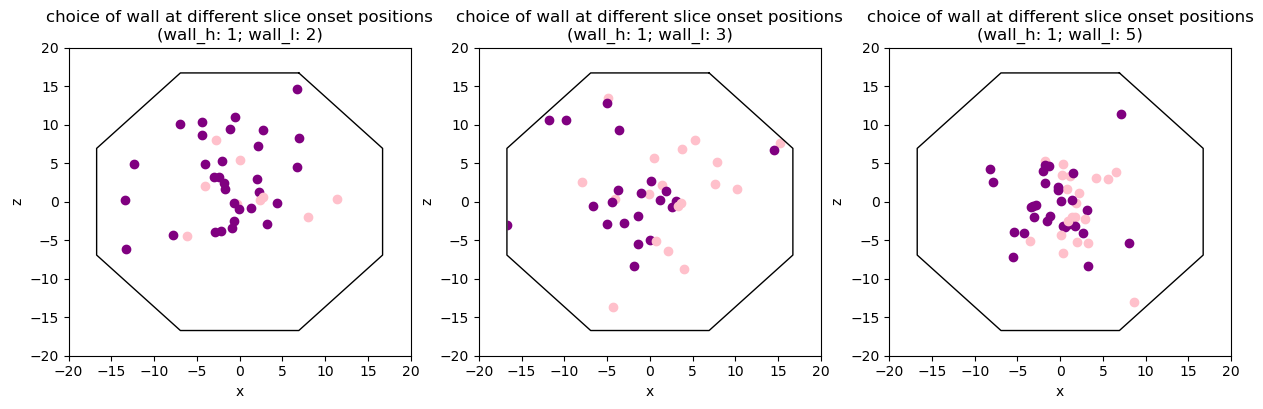

In [52]:
plot_locSC(df_11)

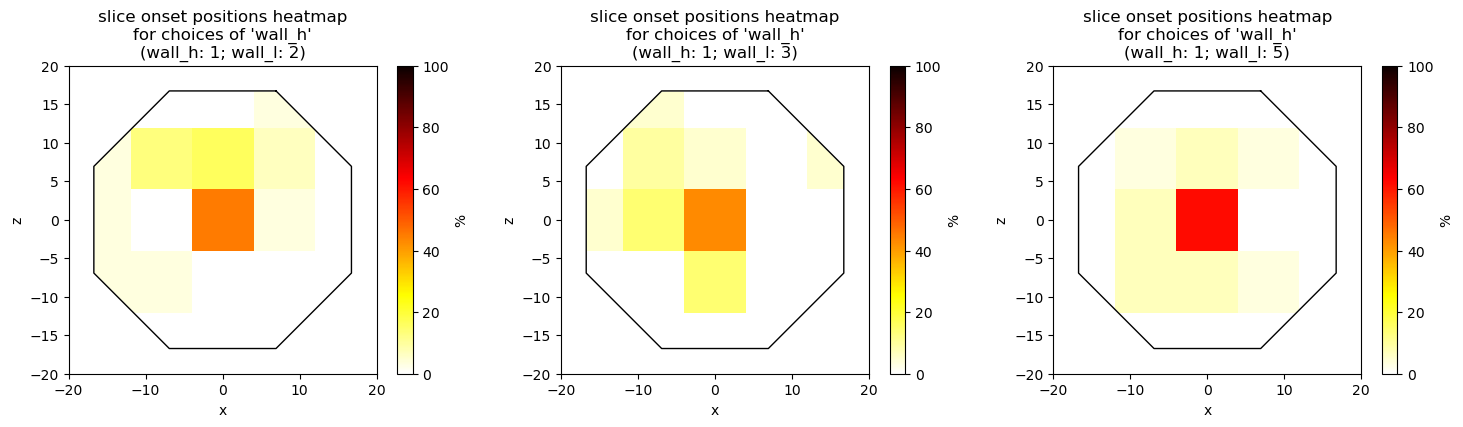

In [53]:
plot_locHM(df_11)

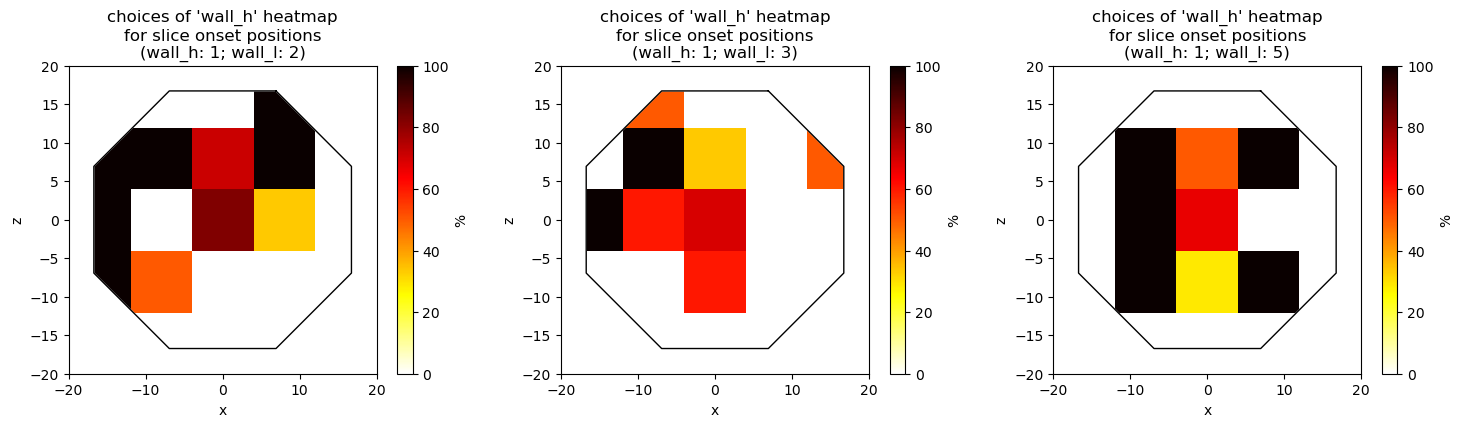

In [54]:
plot_choiceHM(df_11)

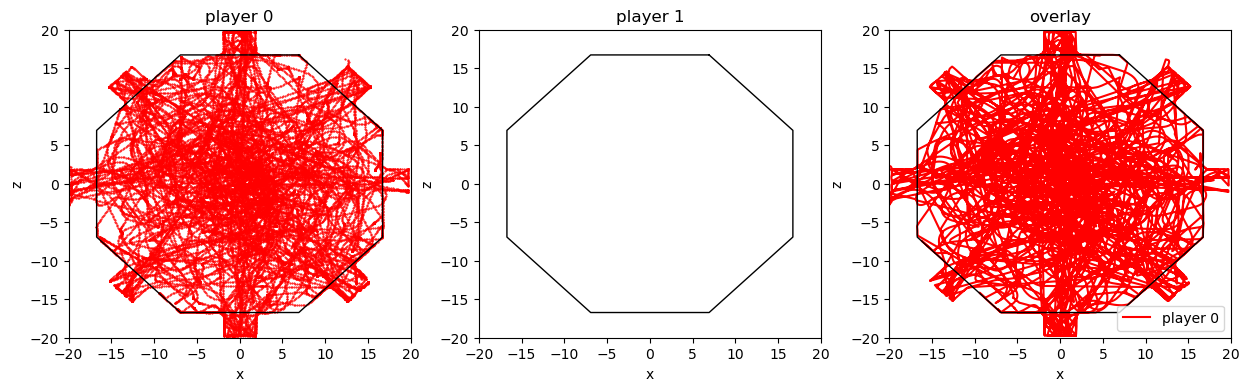

In [57]:
plot_full_trajectory(df_11)

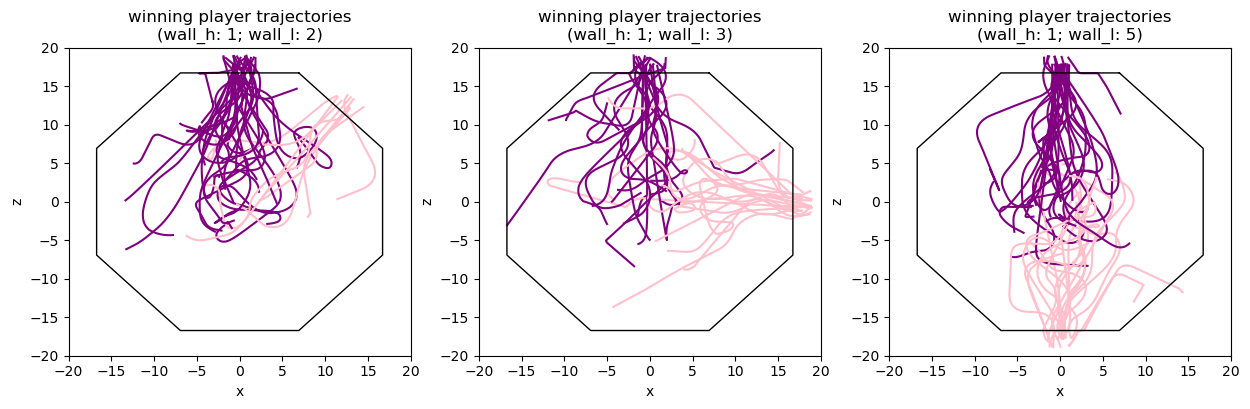

In [58]:
plot_trials_trajectory(df_11)

In [ ]:
def split_trials(df):
    
    triggerNum = get_triggerNum(df)
    
    trials_dict = {}
    
    for i in triggerNum:
        
        df_trial = df[df["data.trialNum"] == i]
        trials_dict[f"trial {int(i)}"] = df_trial #df_trial_startend
    
    return trials_dict

In [ ]:
def filter_trial(df): # df_trial
    
    # extract "time" events only

    df_filtered = df[df["eventDescription"] == "time"]
    
    return df_filtered

In [ ]:
def plot_trial_state(df, ax):

    # align times
    
    df_now = df.copy()
    time_ref = df.iloc[0, df.columns.get_loc("timeApplication")]
    
    for i in range(df.shape[0]):
        
        df_now.iloc[i, df_now.columns.get_loc("timeApplication")] -= time_ref
        
    trial_t = df_now["timeApplication"][1:].tolist()

    # extract events times
    
    t_ts = 0
    t_so = df_now.loc[df_now["eventDescription"] == "slice onset", "timeApplication"].iloc[0]
    t_sta = df_now.loc[df_now["eventDescription"] == "server-selected trigger activation", "timeApplication"].iloc[0]
    t_te = df_now.loc[df_now["eventDescription"] == "trial end", "timeApplication"].iloc[0]
    t_nts = df_now["timeApplication"].iloc[-1]
    
    t_events = [t_ts, t_so, t_sta, t_te, t_nts]
    name_events = ["trial start", "slice onset", "server-selected trigger activation", "trial end", "(next) trial start"]
    
    # plot trial state points (x-axis: time; y-axis: 100)

    for i in range(len(t_events)):
        ax.axvline(x=t_events[i], color='k', linestyle='--')
        ax.text(x=t_events[i], y=100, s=f"{name_events[i]}", rotation=90, verticalalignment='top', horizontalalignment='right', color='k')
        
    ax.set_ylim([0, 100])
    ax.legend()
    
    return

In [ ]:
# distances

In [ ]:
def calc_distance(x1, y1, x2, y2):
    
    distance = ((x2-x1)**2 + (y2-y1)**2)**0.5
    return distance

In [ ]:
def calc_tot_distance(df): #df_trial
    
    df_fil = filter_trial(df)

    tot_distance_0 = 0
    tot_distance_1 = 0

    if "data.playerPosition.0.location.x" in df.columns and "data.playerPosition.0.location.z" in df.columns:
        
        df_x_0 = df_fil["data.playerPosition.0.location.x"]
        df_z_0 = df_fil["data.playerPosition.0.location.z"]

        for i in range(1, df_fil.shape[0]-1): # ignore "trial start"
        
            # calculate distances
        
            distance_0 = calc_distance(df_x_0.iloc[i+1], df_z_0.iloc[i+1], df_x_0.iloc[i], df_z_0.iloc[i])
            
            # sum distances
            
            tot_distance_0 += distance_0
        
    elif "data.playerPosition.0.location.x" in df.columns and "data.playerPosition.0.location.z" in df.columns:
        
        df_x_1 = df_fil["data.playerPosition.1.location.x"]
        df_z_1 = df_fil["data.playerPosition.1.location.x"]

        for i in range(1, df_fil.shape[0]-1): # ignore "trial start"
            
            # calculate distances
            
            distance_1 = calc_distance(df_x_1.iloc[i+1], df_z_1.iloc[i+1], df_x_1.iloc[i], df_z_1.iloc[i])
            
            # sum distances
            
            tot_distance_1 += distance_1
        
    return tot_distance_0, tot_distance_1

In [ ]:
def calc_cumu_distance(df): #df_trial

    df_fil = filter_trial(df)
    
    cumu_distance_0 = [0]
    cumu_distance_1 = [0]
    
    for i in range(1, df_fil.shape[0]-1): # ignore "trial start"
        
        # calculate total distances
        
        tot_distance_0, tot_distance_1 = calc_tot_distance(df_fil.iloc[:i+1])
        
        # append total distances
        
        cumu_distance_0.append(tot_distance_0)
        cumu_distance_1.append(tot_distance_1)
        
    return cumu_distance_0, cumu_distance_1

In [ ]:
def plot_cumu_distance(df, ax):

    df_fil = filter_trial(df)

    # calculate cumulative distances
    
    cumu_distance_0, cumu_distance_1 = calc_cumu_distance(df_fil)
    
    # align times

    df_now = df_fil.copy()
    time_ref = df_fil.iloc[0, df_fil.columns.get_loc("timeApplication")]
    
    for i in range(df_fil.shape[0]):

        df_now.iloc[i, df_now.columns.get_loc("timeApplication")] -= time_ref
        
    trial_t = df_now["timeApplication"][1:].tolist()
    
    # plot distance against time
    
    ax.plot(trial_t, cumu_distance_0, "r-", label="player 0")
    ax.plot(trial_t, cumu_distance_1, "g-", label="player 1")
    ax.set_xlabel("time/s")
    ax.set_ylabel("cumulative distance")
    ax.legend()
    
    return

In [ ]:
# velocities

In [ ]:
def calc_av_velocity(df): #df_trial
    
    df_fil = filter_trial(df)
    
    tot_distance_0, tot_distance_1 = calc_tot_distance(df_fil)
    trial_duration = df_fil.iloc[-1, df.columns.get_loc("timeApplication")] - df_fil.iloc[1, df.columns.get_loc("timeApplication")]
    
    av_velocity_0 = tot_distance_0/trial_duration
    av_velocity_1 = tot_distance_1/trial_duration
    
    return av_velocity_0, av_velocity_1

In [ ]:
def calc_inst_velocity(df): #df_trial

    df_fil = filter_trial(df)

    inst_velocity_0 = []
    inst_velocity_1 = []

    if "data.playerPosition.0.location.x" in df.columns and "data.playerPosition.0.location.z" in df.columns:
    
        df_x_0 = df_fil["data.playerPosition.0.location.x"]
        df_z_0 = df_fil["data.playerPosition.0.location.z"]

        for i in range(1, df_fil.shape[0]-1):
        
            distance_0 = calc_distance(df_x_0.iloc[i+1], df_z_0.iloc[i+1], df_x_0.iloc[i], df_z_0.iloc[i])
            
            inst_duration = df_fil.iloc[i+1, df_fil.columns.get_loc("timeApplication")] - df_fil.iloc[i, df_fil.columns.get_loc("timeApplication")]
            
            if inst_duration != 0:
                inst_velocity_0.append(distance_0/inst_duration)
    
    elif "data.playerPosition.0.location.x" in df.columns and "data.playerPosition.0.location.z" in df.columns:
        
        df_x_1 = df_fil["data.playerPosition.1.location.x"]
        df_z_1 = df_fil["data.playerPosition.1.location.x"]
    
        for i in range(1, df_fil.shape[0]-1):
            
            distance_1 = calc_distance(df_x_1.iloc[i+1], df_z_1.iloc[i+1], df_x_1.iloc[i], df_z_1.iloc[i])
            
            inst_duration = df_fil.iloc[i+1, df_fil.columns.get_loc("timeApplication")] - df_fil.iloc[i, df_fil.columns.get_loc("timeApplication")]
            
            if inst_duration != 0:
                inst_velocity_1.append(distance_1/inst_duration)

    if len(inst_velocity_0) == 0:
        inst_velocity_0 = np.zeros(df_fil.shape[0]-2)
    elif len(inst_velocity_1) == 0:
        inst_velocity_1 = np.zeros(df_fil.shape[0]-2)
        
    return inst_velocity_0, inst_velocity_1

In [ ]:
def plot_inst_velocity(df, ax):

    df_fil = filter_trial(df)

    # calculate instantaneous velocities

    inst_velocity_0, inst_velocity_1 = calc_inst_velocity(df_fil)

    # align times
    
    df_now = df_fil.copy()
    time_ref = df_fil.iloc[0, df_fil.columns.get_loc("timeApplication")]
    
    for i in range(df_fil.shape[0]):

        df_now.iloc[i, df_now.columns.get_loc("timeApplication")] -= time_ref
        
    trial_end_id = df_now.index[df_now["eventDescription"] == "trial end"]
    trial_t = df_now["timeApplication"].drop(trial_end_id)[1:].tolist()
    
    # plot distance against time
    
    ax.plot(trial_t[1:], inst_velocity_0, "r-", label="player 0")
    ax.plot(trial_t[1:], inst_velocity_1, "g-", label="player 1")
    ax.set_xlabel("time/s")
    ax.set_ylabel("instantaneous velocity")
    ax.legend()
    
    return

In [ ]:
df_11_trialdict = split_trials(df_11)
df_11_trial_5 = df_11_trialdict["trial 5"]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

plot_cumu_distance(df_11_trial_5, ax)
plot_trial_state(df_11_trial_5, ax)

NameError: name 'plot_inst_velocity' is not defined

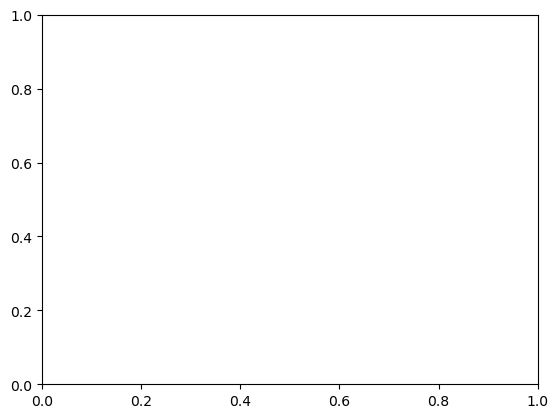

In [56]:
fig = plt.figure()
ax = fig.add_subplot()

plot_inst_velocity(df_11_trial_5, ax)
plot_trial_state(df_11_trial_5, ax)